In [2]:
import k3d
import numpy as np
from matplotlib import pyplot as pp
from scipy.linalg import block_diag
from scipy.sparse import block_diag as block_diag_sp
from scipy.sparse.linalg import lsmr as lstsq_sp

In [9]:
xmin = -100.0
xmax = 100.0
Nx = 50

ymin = -100.0
ymax = 100.0
Ny = 50

zmin = -400.0
zmax = 400.0
Nz = 100

x = np.linspace(xmin, xmax, Nx, dtype=np.float32)
y = np.linspace(ymin, ymax, Ny, dtype=np.float32)
z = np.linspace(zmin, zmax, Nz, dtype=np.float32)
x,y,z = np.meshgrid(x,y,z)

In [10]:
Wx = 14.0 #width in X
Wy = 7.0
angle = 45.*np.pi/180

Exy = 0.0

G00 = 1j*(((np.cos(angle)/Wx)**2) + ((np.sin(angle)/Wy)**2)) + 1/(10.0**2)
G11 = 1j*(((np.sin(angle)/Wx)**2) + ((np.cos(angle)/Wy)**2)) - 1/(10.0**2)
G01 = G10 = -1j*(np.cos(angle)*np.sin(angle))*(1/(Wx**2) - 1/(Wy**2)) #+ 1/100.0
print("G01", G01)

trG0 = G00 + G11
detG0 = (G00*G11) - (G01*G10)

denom = 1 + z*trG0 + (z**2)*detG0

GZ00 = (G00 + z*detG0)/denom
GZ11 = (G11 + z*detG0)/denom
GZ10 = GZ01 = G01/denom

wl = 15.8 #wavelength in um
k = 2*np.pi/wl

U = np.exp(1j*k*(z + GZ00*(x**2) + GZ11*(y**2) + 2*GZ01*x*y))

P = U * U.conjugate()



G01 0.007653061224489796j


In [11]:
plot = k3d.plot()
plt_iso = k3d.marching_cubes(P.real, level=0.2,
                        flat_shading=False)
plot += plt_iso
plot.display()

Output()

Now look at the pre-exponential factor

In [12]:
f00 = 1 + z*G00
f11 = 1 + z*G11
f10 = f01 = z*G10

detEzG = f00*f11 - f10*f01

F = 1/np.sqrt(detEzG)
F.shape

(50, 50, 100)

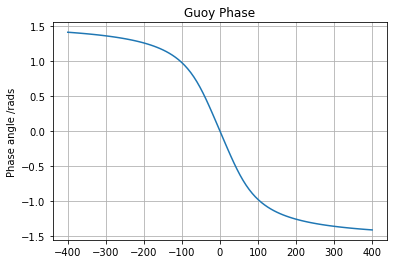

In [18]:
z.shape

phase = np.arctan2(F.imag, F.real)

pp.plot(z[25,25,:], phase[25,25,:])
pp.title("Guoy Phase")
pp.ylabel("Phase angle /rads")
pp.grid(True)

Looks like the Guoy phase comes out of the pre-factor.

# Obtaining Gamma Matrix From Neighbour Rays

In [4]:
from scipy.linalg import lstsq

In [5]:

angles = np.linspace(0,2*np.pi,7)

rot = np.pi*15./180
r = 1/np.sqrt(1-0.8*np.cos(angles-rot)**2)
x = np.cos(angles) * r 
y = np.sin(angles) * r

x += np.random.normal(size=7, scale=0.2)
y += np.random.normal(size=7, scale=0.2)


<IPython.core.display.Javascript object>


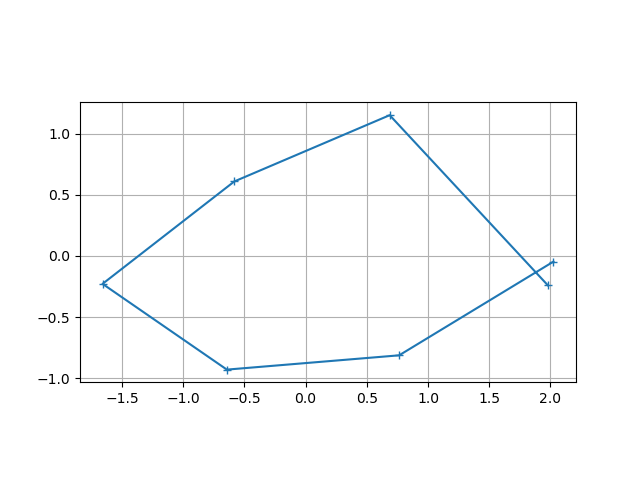

In [6]:
%matplotlib notebook

pp.plot(x,y, '+-')
pp.grid(True)
pp.gca().set_aspect("equal")

In [7]:
# Add noise


M = np.column_stack([x**2, x*y, y**2])[:6,:]
b = np.ones(6)

In [8]:
lstsq(M,b)

(array([ 0.26923515, -0.28170304,  1.01209683]),
 0.43991858053317334,
 3,
 array([4.89570287, 1.88902113, 1.08794317]))

In [257]:
%timeit lstsq(M,b, lapack_driver="gelsd")

98.5 µs ± 431 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [262]:
%timeit lstsq(M,b, lapack_driver="gelsy")

61.2 µs ± 423 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [259]:
%timeit lstsq(M,b, lapack_driver="gelss")

91.4 µs ± 489 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [260]:
M2 = np.array([[1.]])
b2 = np.array([1.])

In [263]:
%timeit lstsq(M2,b2, lapack_driver="gelsy")

55.5 µs ± 193 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
timings = []
for m in [1,2,4,8,12,16,20,32,64,128,256,512,1024]:
    _m = m*10
    M3 = block_diag_sp([M]*_m)
    b3 = np.concatenate([b]*_m)
    #time_vals = %timeit -o lstsq_sp(M3,b3, lapack_driver="gelsy")
    time_vals = %timeit -o lstsq_sp(M3,b3)
    timings.append((_m, time_vals))
    print("Done", _m)

917 µs ± 2.68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Done 100
989 µs ± 3.05 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Done 200
1.12 ms ± 2.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Done 400
1.56 ms ± 12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Done 800
1.94 ms ± 8.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Done 1200
2.1 ms ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Done 1600
2.24 ms ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Done 2000
3.01 ms ± 52.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Done 3200
4.89 ms ± 40 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Done 6400


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


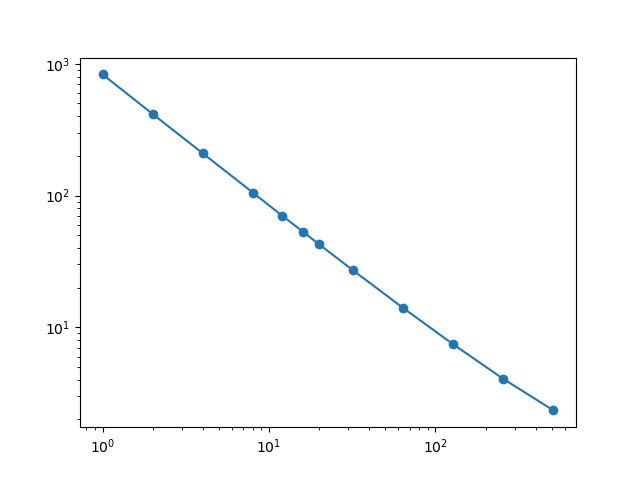

In [298]:
%matplotlib notebook

time_per_block = np.array([t.best/m for m,t in timings])
m_vals = [m for m,t in timings]

pp.loglog(m_vals, time_per_block*1e6, 'o-')

In [301]:
m = 1000
M3 = block_diag_sp([M]*m)
b3 = np.concatenate([b]*m)
x3 = lstsq_sp(M3,b3)

print("Sp:", x3[0][:3])

x = lstsq(M,b)
print("Dense:", x[0])

Sp: [ 0.26121617 -0.29150534  0.78755233]
Dense: [ 0.26121617 -0.29150534  0.78755233]


In [60]:
1/np.sqrt(1j)

(0.7071067811865475-0.7071067811865475j)